In [1]:
from pathlib import Path

import h5py
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd

In [2]:
# Open the H5 file in read mode
with h5py.File('/home/valentin/workspaces/histomining/data/processed/tcga-ut-embeddings/uni2-embeddings.h5', 'r') as f:
    # Load embeddings as numpy array
    embeddings = f['embeddings'][:]  # Shape: (num_samples, embedding_dim)
    
    # Load metadata
    tile_ids = f['tile_ids'][:]  # List of strings
    labels = f['labels'][:]      # List of strings
    
    # Load attributes
    embedding_dim = f.attrs['embedding_dim']
    model_name = f.attrs['model_name']
    num_samples = f.attrs['num_samples']

In [3]:
labels = [l.decode('utf-8') for l in labels]
tile_ids = [t.decode('utf-8') for t in tile_ids]

In [4]:
# Create and fit UMAP
reducer = umap.UMAP(random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

/home/valentin/miniconda3/envs/torchpl/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/valentin/miniconda3/envs/torchpl/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [5]:
labels = np.array(labels)
unique_labels = np.unique(labels)

In [6]:
unique_labels

array(['LUAD', 'NORMAL'], dtype='<U6')

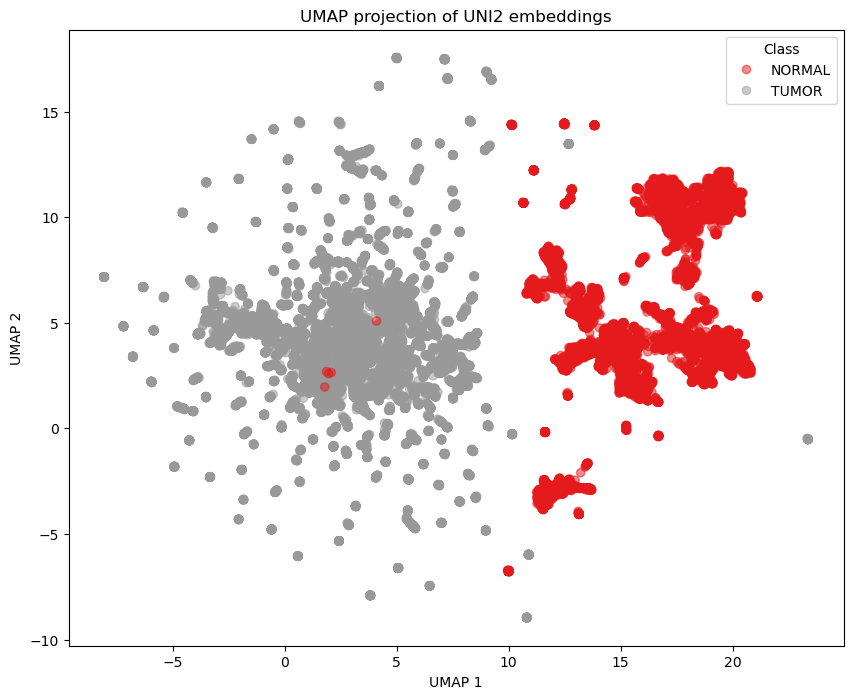

In [7]:
# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=[0 if label == 'NORMAL' else 1 for label in labels],
                     cmap='Set1', alpha=0.5)

# Add legend
plt.legend(handles=scatter.legend_elements()[0], 
          labels=['NORMAL', 'TUMOR'],
          title='Class')

plt.title(f'UMAP projection of {model_name} embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Show plot
plt.show()

In [ ]:
# Create scatter plot with improved styling
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=[0 if label == 'NORMAL' else 1 for label in labels],
                     cmap='RdGy',  # Red-Gray colormap
                     alpha=0.6,    # Slightly more opaque
                     s=50)        # Larger points

# Improve legend and labels
plt.legend(handles=scatter.legend_elements()[0],
          labels=['NORMAL', 'TUMOR'],
          title='Class',
          title_fontsize=12,
          fontsize=10,
          loc='upper right')

plt.title(f'UMAP projection of {model_name} embeddings', fontsize=14, pad=20)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.2)

# Tight layout to prevent label clipping
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# Create separate plots for NORMAL and TUMOR
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot NORMAL samples
normal_mask = labels == 'NORMAL'
ax1.scatter(embeddings_2d[normal_mask, 0], 
           embeddings_2d[normal_mask, 1],
           c='red',
           alpha=0.6,
           s=50)
ax1.set_title('NORMAL samples')
ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')
ax1.grid(True, alpha=0.2)

# Plot TUMOR samples
tumor_mask = labels == 'LUAD'
ax2.scatter(embeddings_2d[tumor_mask, 0], 
           embeddings_2d[tumor_mask, 1],
           c='gray',
           alpha=0.6,
           s=50)
ax2.set_title('TUMOR samples')
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')
ax2.grid(True, alpha=0.2)

# Set consistent axis limits for both plots
xlim = (embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max())
ylim = (embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max())
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of NORMAL samples: {normal_mask.sum()}")
print(f"Number of TUMOR samples: {tumor_mask.sum()}")

In [ ]:
# Add a new cell to check tile_ids distribution
print("Example NORMAL tile paths:")
normal_ids = [tid for tid, label in zip(tile_ids, labels) if label == 'NORMAL']
print("\n".join(normal_ids[:5]))

print("\nExample TUMOR tile paths:")
tumor_ids = [tid for tid, label in zip(tile_ids, labels) if label == 'LUAD']
print("\n".join(tumor_ids[:5]))

In [ ]:
def get_image_stats(image_path):
    """Get basic image statistics"""
    img = np.array(Image.open(image_path))
    return {
        'mean': img.mean(),
        'std': img.std(),
        'min': img.min(),
        'max': img.max()
    }



In [ ]:
len(labels)

In [ ]:
# Sample some images from each dataset
normal_data_dir = Path("/mnt/nas7/data/Personal/Valentin/tcga-ut/Lung_normal/0")
normal_paths = [Path(tid) for tid in normal_ids[:100]]  # First 100 CPTAC normal images
tumor_paths = [Path(tid) for tid in tumor_ids[:100]]   # First 100 TCGA tumor images

# Collect statistics
normal_stats = pd.DataFrame([get_image_stats(p) for p in normal_paths])
tumor_stats = pd.DataFrame([get_image_stats(p) for p in tumor_paths])

# Compare distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for (stat, ax) in zip(['mean', 'std', 'min', 'max'], axes.ravel()):
    ax.hist(normal_stats[stat], alpha=0.5, label='CPTAC Normal', bins=30)
    ax.hist(tumor_stats[stat], alpha=0.5, label='TCGA Tumor', bins=30)
    ax.set_title(f'Distribution of {stat}')
    ax.legend()

plt.tight_layout()
plt.show()